# Comparing Phoenix Spectra

Plot Phoenix aces and Phoenix BT-Settl for same parameters

Also AMES Dusty Cond.

#### FORMAT OF THE SPECTRA OUTPUT FILES

You can find the  pre-computed grids, also accessible via links on
the bottom part of the simulator presentation page, or using this link:
http://phoenix.ens-lyon.fr/Grids/

The file names contain the main parameters of the models:
lte{Teff/10}-{Logg}{[M/H]}a[alpha/H].GRIDNAME.7.spec.gz/bz2/xz
is the synthetic spectrum for the requested effective temperature
(Teff),surface gravity (Logg), metallicity by log10 number density with
respect to solar values ([M/H]), and alpha element enhencement relative     
to solar values [alpha/H]. The model grid is also mentioned in the name.

Spectra are provided in an ascii format (\*.7.gz):

column1: wavelength in Angstroem
column2: 10\*\*(F_lam + DF) to convert to Ergs/sec/cm\*\*2/A
column3: 10\*\*(B_lam + DF) i.e. the blackbody fluxes of same Teff in same units.

Additional columns, obtained systematically when computing spectra using the
Phoenix simulator, give the information to identify atomic and molecular
lines. This information is used by the idl scripts lineid.pro and plotid.pro 
which are provided in the user result package.  
   
With the stacked ascii format (\*.spec.gz files ) we have rather:

line1: Teff logg [M/H] of the model
line2: number of wavelengths
line3: F_lam(n) X 10\*\*DF , n=1,number of wavelengths
lineX: B_lam(n) X 10\*\*DF , n=1,number of wavelengths


In [1]:
#from utilities.phoenix_utils import load_starfish_spectrum, load_phoenix_spectrum

import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import string
import numpy as np
from astropy.io import fits

%matplotlib inline

In [2]:
os.chdir("/home/jneal/Phd/2017/Compare_PHOENIX/")
os.getcwd()
files = glob.glob("data/*")
# print(files)

In [3]:
def load_phoenix_aces(fname):
    """
    Returns
    -------
    wavelength  (nanometers)
    flux        ('erg/s/cm^2/cm' )
    """
    fits.getdata(fname)
    wav = "data/WAVE_PHOENIX-ACES-AGSS-COND-2011.fits"
    return fits.getdata(wav) / 10, fits.getdata(fname)


In [4]:
def get_DF(fname):
    """Specify the DF value for equation.
    
    DF= -8.d0 for all most recent models (Ergs/sec/cm**2/cm). For older model
    series like the NextGen and AMES-Cond grids DF= -26.9007901434d0, 
    because previous Phoenix outputs were giving out the luminosity, 
    L (= R**2 * H) in erg/s/cm**2/cm.  And for NextGen spectra
    of effective temperature 5000K and above, DF'= -28.9007901434d0.

    Note: Jason assumes there is a typo above and it is  /A instead of cm for Df=-8.
        To match the flux units for column 2."""

    if "AMES-Cond" in fname:
        DF = np.float(-26.9007901434E0)
    else:
        DF = np.float(-8.E0)
        # print("DF = {0}".format(DF))
    return DF
    

def load_Allard_Phoenix(fname):
    """Load the Phoenix models from France Allard.
    
    Input
    -----
    fname: str
        Filename of Phoenix spectra.
        
    Returns
    -------
    wavelength          (nanometers)
    flux                (Ergs/sec/cm**2/A)
    black body flux     (Ergs/sec/cm**2/A)
    """

    DF = get_DF(fname)

    if fname.endswith(".7"):
        # Spectra are provided in an ascii format (*.7.gz):
        df = pd.read_table(fname, delim_whitespace=True, header=None, usecols=[0, 1, 2])
        df = df.astype(str)
        df[0] = df[0].str.replace("D", "E")
        df[1] = df[1].str.replace("D", "E")
        df[2] = df[2].str.replace("D", "E")
        df.columns = ["wavelength", "flux", "bb_flux"]
        df = df.astype(np.float64)

        # ***A very important point is that since models are often computed on parallel
        # computers using several nodes, it is important to sort the spectra files in
        # increasing wavelength order prior to using them.***
        df.sort_values(by="wavelength")
        
        # Cut db
        df = df[(df["wavelength"] > 3000) & (df["wavelength"] < 50000)]
        # column1: wavelength in Angstrom
        # column2: 10**(F_lam + DF) to convert to Ergs/sec/cm**2/A
        # column3: 10**(B_lam + DF) i.e. the blackbody fluxes of same Teff in same units.
        wavelength = df["wavelength"].values / 10  # to nanometers
        flux = 10 ** (df["flux"].values + DF)  # Ergs/sec/cm**2/A
        bb_flux = 10 ** (df["bb_flux"].values + DF)  # blackbody fluxes

    elif fname.endswith(".7"):
        # With the stacked ascii format (*.spec.gz files ) we have rather:
        # line1: Teff logg [M/H] of the model
        # line2: number of wavelengths
        # line3: F_lam(n) X 10**DF , n=1,number of wavelengths
        # lineX: B_lam(n) X 10**DF , n=1,number of wavelengths
        # This older file format is no longer used and no ID output is provided with those files.
        raise NotImplementedError
    elif fname.endswith("cf128.sc.spid.fits"):
        data = fits.getdata(fname)
        wavelength = data["wavelength"]
        flux = data["flux"]
        bb_flux = np.nan * np.ones_like(flux)        
    else:
        raise NotImplementedError("For spectra like {}".format(fname))
    
    index = wavelength.argsort()
    return wavelength[index], flux[index], bb_flux[index]


def plot_allard_phoenix(fname, band=None):
    wav, flux, bb_flux = load_Allard_Phoenix(fname)
    plt.figure(figsize=(10, 8))
    plt.plot(wav, flux, label="flux")
    plt.plot(wav, bb_flux, label="bb_flux")
    plt.legend()
    plt.title(fname)
    plt.xlabel("Wavelength")
    plt.ylabel("Flux")


(1336340, 4)
[[  1.00000000e+00  -9.27740000e+01  -9.27740000e+01   5.40000000e+01]
 [  1.05000000e+00  -9.27740000e+01  -9.27740000e+01   5.10000000e+01]
 [  1.10000000e+00  -9.27740000e+01  -9.27740000e+01   4.90000000e+01]
 ..., 
 [  9.98500000e+06   2.89872000e+00   3.05042000e+00   3.80000000e+01]
 [  9.99000000e+06   2.89784000e+00   3.04955000e+00   3.80000000e+01]
 [  9.99500000e+06   2.89697000e+00   3.04869000e+00   3.80000000e+01]]


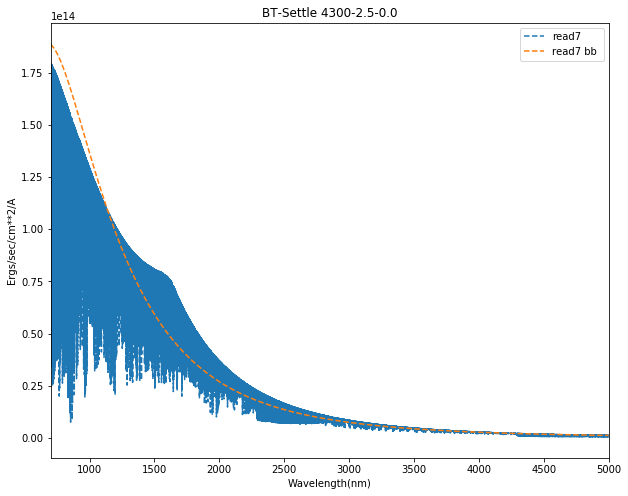

In [5]:
from PyAstronomy.pyasl.phoenixUtils.read import readUnit7, readDTable, decomposeFilename
#readUnit7 is in units of per cm not per A

decomposeFilename("lte4300-2.50-0.0a+0.0.BT-dusty-giant-2013.cf128.sc.spid.fits")




read7 = readUnit7("data/lte043.0-2.5-0.0a+0.0.BT-Settl.spec.7")
print(read7.shape)
print(read7)
plt.figure(figsize=(10, 8))
plt.plot(read7[:, 0]/10, 10**read7[:, 1], "--", label="read7")
plt.plot(read7[:, 0]/10, 10**read7[:, 2], "--", label="read7 bb ")
plt.legend()
plt.xlim([700, 5000])
plt.xlabel("Wavelength(nm)")
plt.ylabel("Ergs/sec/cm**2/A")
plt.title("BT-Settle 4300-2.5-0.0")
plt.show()


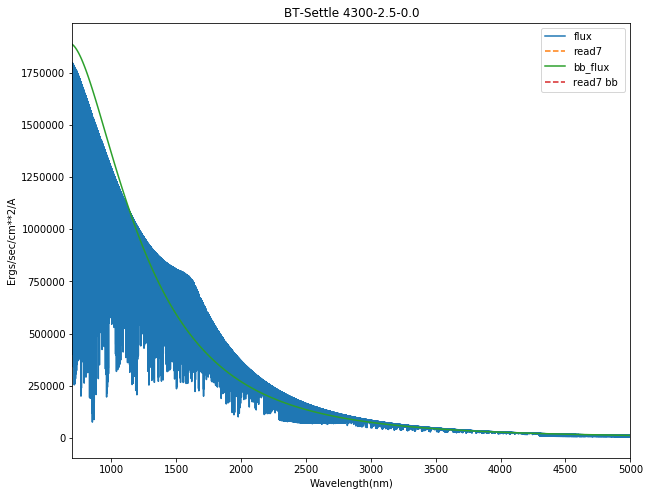

In [6]:
wav, flux, bb_flux = load_Allard_Phoenix("data/lte043.0-2.5-0.0a+0.0.BT-Settl.spec.7")
read7 = readUnit7("data/lte043.0-2.5-0.0a+0.0.BT-Settl.spec.7")
plt.figure(figsize=(10, 8))
plt.plot(wav, flux, label="flux")
plt.plot(read7[0], read7[1], "--", label="read7")
plt.plot(wav, bb_flux, label="bb_flux")
plt.plot(read7[0], read7[1], "--", label="read7 bb ")
plt.legend()
plt.xlim([700, 5000])
plt.xlabel("Wavelength(nm)")
plt.ylabel("Ergs/sec/cm**2/A")
plt.title("BT-Settle 4300-2.5-0.0")
plt.show()


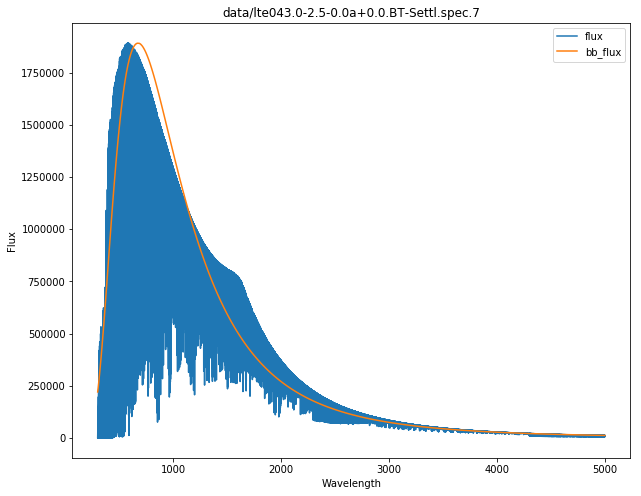

In [7]:
plot_allard_phoenix("data/lte043.0-2.5-0.0a+0.0.BT-Settl.spec.7")
plt.show()

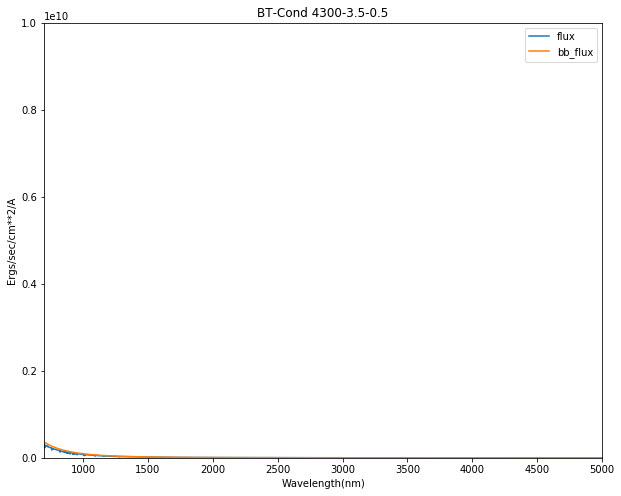

In [8]:
wav, flux, bb_flux = load_Allard_Phoenix("data/lte430-3.5-0.5a+0.2.BT-Cond.7")

plt.figure(figsize=(10, 8))
plt.plot(wav, flux, label="flux")
plt.plot(wav, bb_flux, label="bb_flux")
plt.legend()
plt.xlim([700, 5000])
plt.ylim([1e1, 1e10])
plt.xlabel("Wavelength(nm)")
plt.ylabel("Ergs/sec/cm**2/A")
plt.title("BT-Cond 4300-3.5-0.5")
#plt.ylim([10, 18])
plt.show()

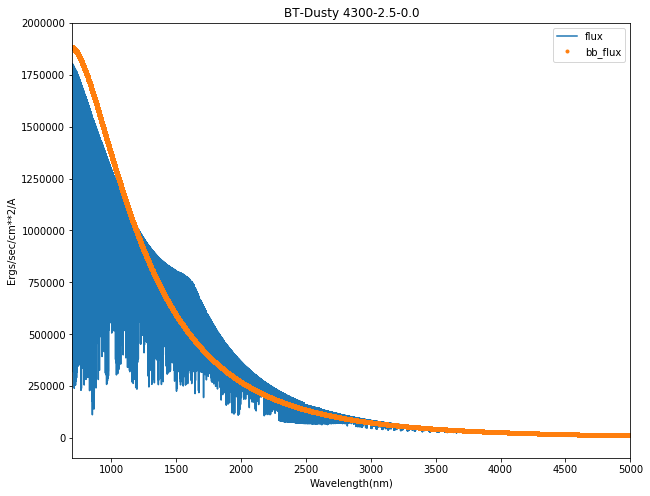

In [9]:

wav, flux, bb_flux = load_Allard_Phoenix("data/lte043-2.5-0.0.BT-Dusty.spec.7")

plt.figure(figsize=(10, 8))
plt.plot(wav, flux, label="flux")
plt.plot(wav, bb_flux, ".", label="bb_flux")
plt.legend()
plt.xlim([700, 5000])
plt.xlabel("Wavelength(nm)")
plt.ylabel("Ergs/sec/cm**2/A")
plt.title("BT-Dusty 4300-2.5-0.0")
plt.legend()
plt.show()

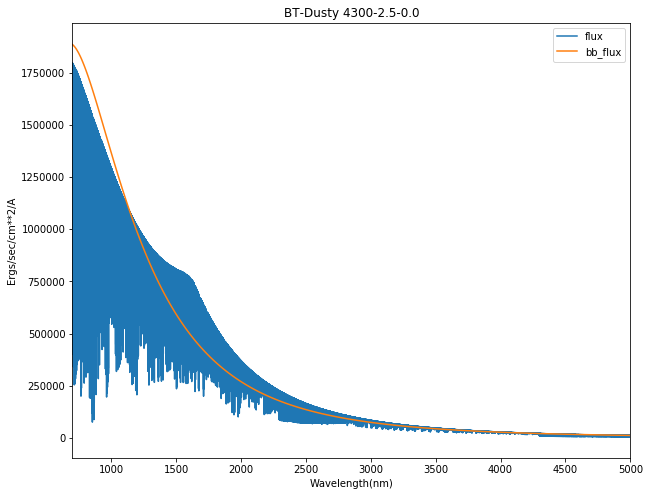

In [10]:

wav, flux, bb_flux = load_Allard_Phoenix("data/lte043.0-2.5-0.0a+0.0.BT-Settl.spec.7")

plt.figure(figsize=(10, 8))
plt.plot(wav, flux, label="flux")
plt.plot(wav, bb_flux, label="bb_flux")
plt.legend()
plt.xlim([700, 5000])
plt.xlabel("Wavelength(nm)")
plt.ylabel("Ergs/sec/cm**2/A")
plt.title("BT-Dusty 4300-2.5-0.0")
plt.legend()
plt.show()

### COMPARING MODELS

In [11]:
Artucus = [4300, 1.50, -0.5]
HD30501 = [5200, 4.5, 0.0]
ACES_bottom = [2300, 4.5, 0.0]
Sun = [5800, 4.5, 0.0]

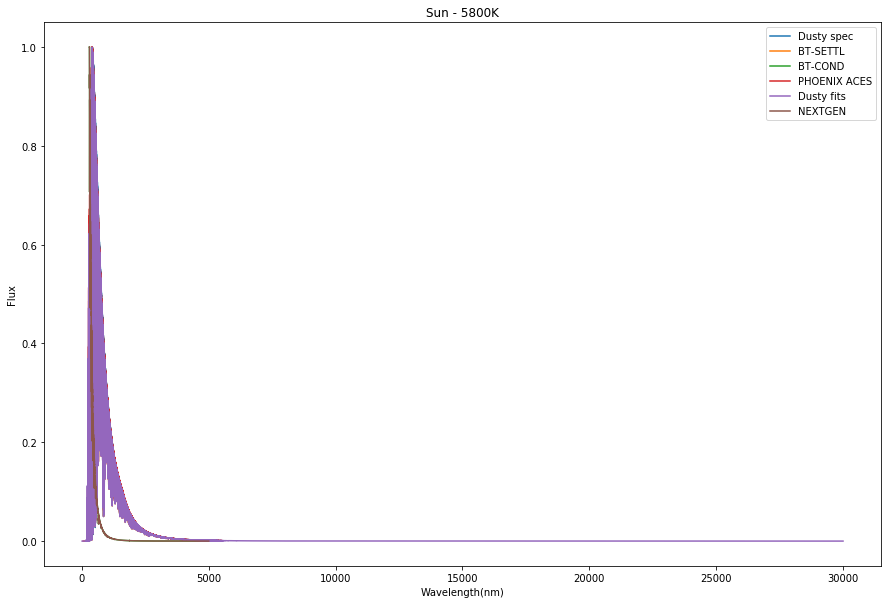

In [12]:
# Teff 5800, 4.5, 0.0
# comparison_plot("Sun", *Sun)
from spectrum_overload import Spectrum


w_next, f_next, bb_next = load_Allard_Phoenix("data/lte580-4.5-0.0a+0.0.BT-NextGen.7")
next_spec = Spectrum(xaxis=w_next, flux=f_next) 
w_dusty_spec, f_dusty_spec, bb_dusty_spec = load_Allard_Phoenix("data/lte058-4.5-0.0.BT-Dusty.spec.7")
dusty_spec = Spectrum(xaxis=w_dusty_spec, flux=f_dusty_spec) 
w_settl, f_settl, bb_settl = load_Allard_Phoenix("data/lte058.0-4.5-0.0a+0.0.BT-Settl.spec.7")
settl_spec = Spectrum(xaxis=w_settl, flux=f_settl) 
w_cond, f_cond, bb_cond = load_Allard_Phoenix("data/lte580-4.5-0.0a+0.0.BT-Cond.7")
cond_spec = Spectrum(xaxis=w_cond, flux=f_cond) 
w_aces, f_aces = load_phoenix_aces("data/lte05800-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits")
aces_spec = Spectrum(xaxis=w_aces, flux=f_aces) 
w_dusty_fits, f_dusty_fits, bb_dusty_fits = load_Allard_Phoenix("data/lte5800-4.50-0.0a+0.0.BT-dusty-giant-2013.cf128.sc.spid.fits")
w_dusty_fits = w_dusty_fits*1000
dusty_fits_spec = Spectrum(xaxis=w_dusty_fits, flux=f_dusty_fits) 

plt.figure(figsize=(15, 10))
plt.plot(w_dusty_spec, f_dusty_spec/max(f_dusty_spec), label="Dusty spec")
plt.plot(w_settl, f_settl/max(f_settl), label="BT-SETTL")
plt.plot(w_cond, f_cond/max(f_cond), label="BT-COND")
plt.plot(w_aces, f_aces/max(f_aces), label="PHOENIX ACES")
plt.plot(w_dusty_fits, f_dusty_fits/max(f_dusty_fits), label="Dusty fits")
plt.plot(w_next, f_next/max(f_next), label="NEXTGEN")
plt.title("Sun - 5800K")
plt.xlabel("Wavelength(nm)")
plt.ylabel("Flux")
plt.legend()
plt.show()

In [13]:
limits = [2116, 2120]
next_spec.wav_select(*limits)
#print(next_spec.xaxis, next_spec.flux)
next_spec = next_spec.normalize("exponential")
dusty_spec.wav_select(*limits)
dusty_spec = dusty_spec.normalize("exponential")
settl_spec.wav_select(*limits)
settl_spec = settl_spec.normalize("exponential")
cond_spec.wav_select(*limits)
cond_spec = cond_spec.normalize("exponential")
aces_spec.wav_select(*limits)
aces_spec = aces_spec.normalize("exponential")
dusty_fits_spec.wav_select(*limits)
dusty_fits_spec = dusty_fits_spec.normalize("exponential")


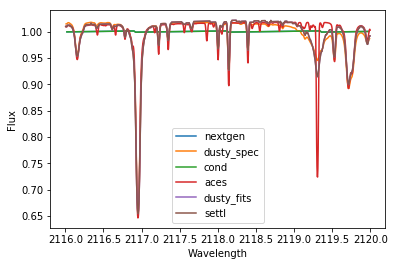

In [14]:

next_spec.plot(label="nextgen")
dusty_spec.plot(label="dusty_spec")
cond_spec.plot(label="cond")
aces_spec.plot(label="aces")
dusty_fits_spec.plot(label="dusty_fits")
settl_spec.plot(label="settl")
plt.legend()
plt.show()

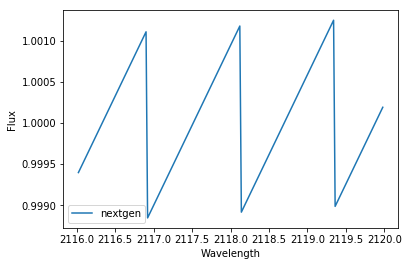

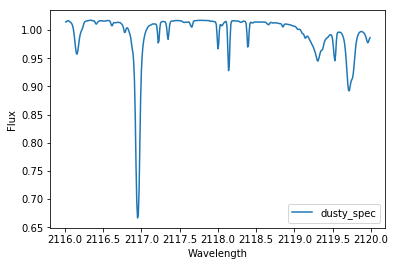

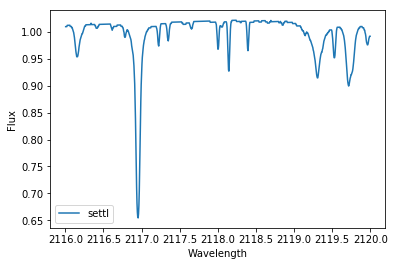

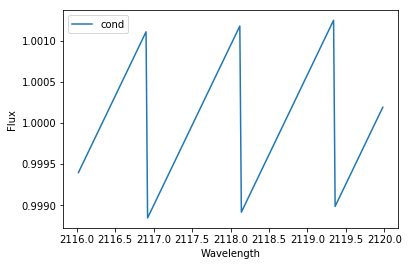

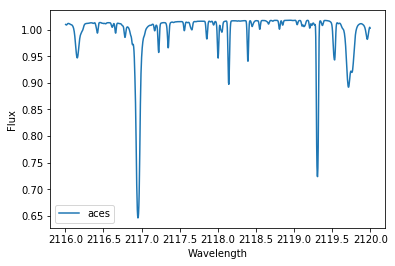

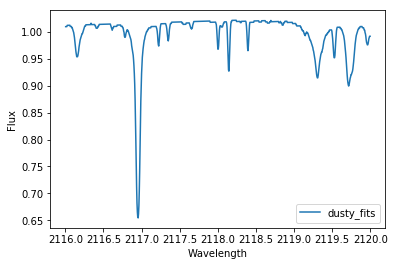

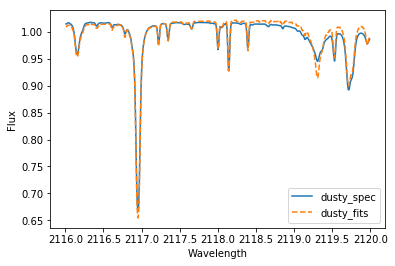

In [15]:

next_spec.plot(label="nextgen")
plt.legend()
plt.show()
dusty_spec.plot(label="dusty_spec")
plt.legend()
plt.show()
settl_spec.plot(label="settl")
plt.legend()
plt.show()
cond_spec.plot(label="cond")
plt.legend()
plt.show()
aces_spec.plot(label="aces")
plt.legend()
plt.show()
dusty_fits_spec.plot(label="dusty_fits")

plt.legend()
plt.show()

dusty_spec.plot(label="dusty_spec")
dusty_fits_spec.plot(linestyle="--",label="dusty_fits")
plt.legend()
plt.show()

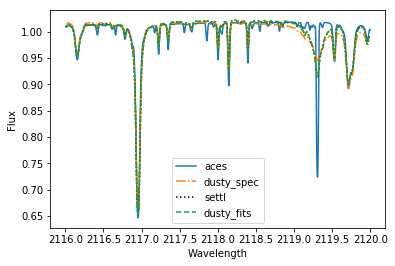

In [16]:
aces_spec.plot(label="aces")
dusty_spec.plot(linestyle="-.", label="dusty_spec")
settl_spec.plot(linestyle=":", color="k", label="settl")
dusty_fits_spec.plot(linestyle="--", label="dusty_fits")

plt.legend()
plt.show()

## PHONEIX ACES Limit - Teff 2300, 4.5, 0.0

In [17]:

# comparison_plot("ACES_bottom", *ACES_bottom)

w_next, f_next, bb_next = load_Allard_Phoenix("data/lte023-5.0-0.0.BT-NextGen.7")
next_spec = Spectrum(xaxis=w_next, flux=f_next) 

w_dusty_spec, f_dusty_spec, bb_dusty_spec = load_Allard_Phoenix("data/lte023-4.5-0.0.BT-Dusty.spec.7")
dusty_spec = Spectrum(xaxis=w_dusty_spec, flux=f_dusty_spec) 

w_settl, f_settl, bb_settl = load_Allard_Phoenix("data/lte023.0-4.5-0.0a+0.0.BT-Settl.spec.7")
settl_spec = Spectrum(xaxis=w_settl, flux=f_settl) 

w_cond, f_cond, bb_cond = load_Allard_Phoenix("data/lte230-4.5-0.0a+0.0.BT-Cond.7")
cond_spec = Spectrum(xaxis=w_cond, flux=f_cond) 

w_aces, f_aces = load_phoenix_aces("data/lte02300-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits")
aces_spec = Spectrum(xaxis=w_aces, flux=f_aces) 
w_dusty_fits, f_dusty_fits, bb_dusty_fits = load_Allard_Phoenix("data/lte5800-4.50-0.0a+0.0.BT-dusty-giant-2013.cf128.sc.spid.fits")
w_dusty_fits = w_dusty_fits*1000
dusty_fits_spec = Spectrum(xaxis=w_dusty_fits, flux=f_dusty_fits) 


limits = [2100, 2200]
next_spec.wav_select(*limits)
# print(next_spec.xaxis, next_spec.flux)
next_spec = next_spec.normalize("exponential")
dusty_spec.wav_select(*limits)
dusty_spec = dusty_spec.normalize("exponential")
settl_spec.wav_select(*limits)
settl_spec = settl_spec.normalize("exponential")
cond_spec.wav_select(*limits)
cond_spec = cond_spec.normalize("exponential")
aces_spec.wav_select(*limits)
aces_spec = aces_spec.normalize("exponential")
dusty_fits_spec.wav_select(*limits)
dusty_fits_spec = dusty_fits_spec.normalize("exponential")



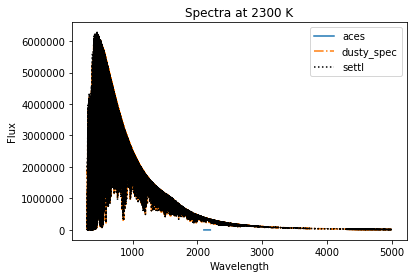

In [22]:

aces_spec.plot(label="aces")
dusty_spec.plot(linestyle="-.", label="dusty_spec")
settl_spec.plot(linestyle=":", color="k", label="settl")

plt.title("Spectra at 2300 K")
plt.legend()
plt.show()

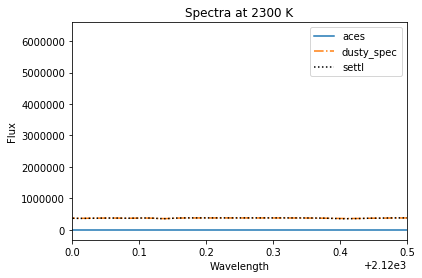

In [24]:

aces_spec.plot(label="aces")
dusty_spec.plot(linestyle="-.", label="dusty_spec")
settl_spec.plot(linestyle=":", color="k", label="settl")

plt.title("Spectra at 2300 K")
plt.xlim([2120, 2120.5])
plt.legend()
plt.show()

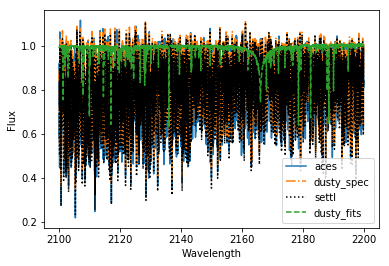

In [20]:
aces_spec.plot(label="aces")
dusty_spec.plot(linestyle="-.", label="dusty_spec")
settl_spec.plot(linestyle=":", color="k", label="settl")
dusty_fits_spec.plot(linestyle="--", label="dusty_fits")

plt.legend()
plt.show()

In [25]:
# Teff 5200, 4.5, 0.0
# HD30501 Host

w_next, f_next, bb_next = load_Allard_Phoenix("data/lte520-4.5-0.0a+0.0.BT-NextGen.7")
next_spec = Spectrum(xaxis=w_next, flux=f_next) 

w_dusty_spec, f_dusty_spec, bb_dusty_spec = load_Allard_Phoenix("data/lte052-4.5-0.0.BT-Dusty.spec.7")
dusty_spec = Spectrum(xaxis=w_dusty_spec, flux=f_dusty_spec) 

w_settl, f_settl, bb_settl = load_Allard_Phoenix("data/lte052.0-4.5-0.0a+0.0.BT-Settl.spec.7")
settl_spec = Spectrum(xaxis=w_settl, flux=f_settl) 

w_cond, f_cond, bb_cond = load_Allard_Phoenix("data/lte520-4.5-0.5a+0.0.BT-Cond.7")
cond_spec = Spectrum(xaxis=w_cond, flux=f_cond) 

w_aces, f_aces = load_phoenix_aces("data/lte05200-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits")
aces_spec = Spectrum(xaxis=w_aces, flux=f_aces) 

w_dusty_fits, f_dusty_fits, bb_dusty_fits = load_Allard_Phoenix("data/lte5200-4.50-0.0a+0.0.BT-dusty-giant-2013.cf128.sc.spid.fits")
w_dusty_fits = w_dusty_fits*1000
dusty_fits_spec = Spectrum(xaxis=w_dusty_fits, flux=f_dusty_fits) 



FileNotFoundError: File b'data/lte520-4.5-0.5a+0.0.BT-Cond.7' does not exist

In [ ]:

limits = [2100, 2200]
next_spec.wav_select(*limits)
print(next_spec.xaxis, next_spec.flux)
next_spec = next_spec.normalize("exponential")
dusty_spec.wav_select(*limits)
dusty_spec = dusty_spec.normalize("exponential")
settl_spec.wav_select(*limits)
settl_spec = settl_spec.normalize("exponential")
cond_spec.wav_select(*limits)
cond_spec = cond_spec.normalize("exponential")
aces_spec.wav_select(*limits)
aces_spec = aces_spec.normalize("exponential")
dusty_fits_spec.wav_select(*limits)
dusty_fits_spec = dusty_fits_spec.normalize("exponential")


In [ ]:
aces_spec.plot(label="aces")
dusty_spec.plot(linestyle="-.", label="dusty_spec")
settl_spec.plot(linestyle=":", color="k", label="settl")
dusty_fits_spec.plot(linestyle="--", label="dusty_fits")

plt.legend()
plt.show()

# Comparing to ARTUCUS

it is 100000 Resolving power

In [28]:
files_1 = glob.glob("/home/jneal/Phd/data/artucus/1*.fits")
files_2 = glob.glob("/home/jneal/Phd/data/artucus/2*.fits")
for f in files_1:
    print(f)
for f in files_2:
    print(f)

/home/jneal/Phd/data/artucus/10046-10104_s-obs.fits
/home/jneal/Phd/data/artucus/10097-10155_s-obs.fits
/home/jneal/Phd/data/artucus/10252-10312_s-obs.fits
/home/jneal/Phd/data/artucus/10200-10259_s-obs.fits
/home/jneal/Phd/data/artucus/10148-10207_s-obs.fits
/home/jneal/Phd/data/artucus/20933-21065_s-obs.fits
/home/jneal/Phd/data/artucus/21043-21177_s-obs.fits
/home/jneal/Phd/data/artucus/21267-21403_s-obs.fits
/home/jneal/Phd/data/artucus/20824-20955_s-obs.fits
/home/jneal/Phd/data/artucus/21611-21752_s-obs.fits
/home/jneal/Phd/data/artucus/21380-21518_s-obs.fits
/home/jneal/Phd/data/artucus/21847-21992_s-obs.fits
/home/jneal/Phd/data/artucus/21967-22113_s-obs.fits
/home/jneal/Phd/data/artucus/21729-21871_s-obs.fits
/home/jneal/Phd/data/artucus/21495-21635_s-obs.fits


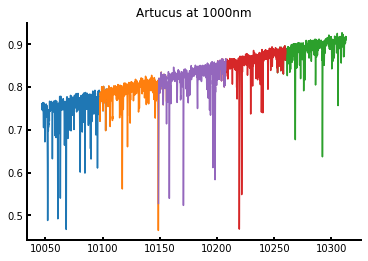

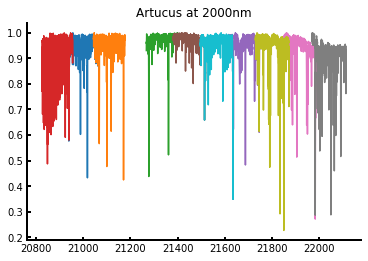

In [29]:
from astro_scripts.plot_fits import get_wavelength


for f in files_1:
    data, hdr = fits.getdata(f, header=True)
    wave = get_wavelength(hdr, convert=False)
    
    plt.plot(wave, data)
plt.title("Artucus at 1000nm")
plt.show()

for f in files_2:
    data, hdr = fits.getdata(f, header=True)
    wave = get_wavelength(hdr, convert=False)
    
    plt.plot(wave, data)
plt.title("Artucus at 2000nm")
plt.show()

In [30]:
from spectrum_overload import Spectrum


artucus_1 = "/home/jneal/Phd/data/artucus/10097-10155_s-obs.fits"
data, hdr = fits.getdata(artucus_1, header=True)

artucus_1 = Spectrum(xaxis=get_wavelength(hdr)/10, flux=data, header=hdr )

artucus_2 = "/home/jneal/Phd/data/artucus/21380-21518_s-obs.fits"
data, hdr = fits.getdata(artucus_2, header=True)

artucus_2 = Spectrum(xaxis=get_wavelength(hdr)/10, flux=data, header=hdr)

# Comparing Artucus at 1um

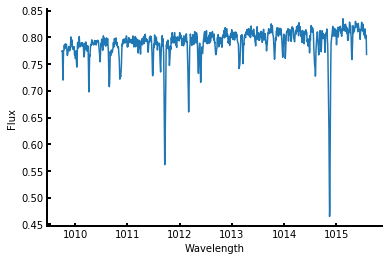

In [31]:
artucus_1.plot()
plt.show()


In [ ]:
artucus_2.plot()
plt.show()

In [36]:
# Teff 4300, 1.5 logg, -0.5 [Fe/H]
# comparison_plot("Artucus", *Artucus)

w_next, f_next, bb_next = load_Allard_Phoenix("data/lte043-2.5-0.0a+0.0.BT-NextGen.7")
next_spec = Spectrum(xaxis=w_next, flux=f_next) 

w_dusty_spec, f_dusty_spec, bb_dusty_spec = load_Allard_Phoenix("data/lte043-2.5-0.0.BT-Dusty.spec.7")
dusty_spec = Spectrum(xaxis=w_dusty_spec, flux=f_dusty_spec) 

w_settl, f_settl, bb_settl = load_Allard_Phoenix("data/lte043.0-2.5-0.0a+0.0.BT-Settl.spec.7")
settl_spec = Spectrum(xaxis=w_settl, flux=f_settl) 

w_cond, f_cond, bb_cond = load_Allard_Phoenix("data/lte043-2.5-0.0a+0.0.BT-Cond.7")
cond_spec = Spectrum(xaxis=w_cond, flux=f_cond) 

w_aces, f_aces = load_phoenix_aces("data/lte04300-1.50-0.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits")
aces_spec = Spectrum(xaxis=w_aces, flux=f_aces) 

#w_dusty_fits, f_dusty_fits, bb_dusty_fits = load_Allard_Phoenix("data/lte4300-2.50-0.0a+0.0.BT-dusty-giant-2013.cf128.vo0.spid.fits")
#w_dusty_fits = w_dusty_fits*1000
#dusty_fits_spec = Spectrum(xaxis=w_dusty_fits, flux=f_dusty_fits) 


In [33]:
limits = [2100, 2200]
limits = [artucus_1.xaxis[0], artucus_1.xaxis[-1]]
next_spec.wav_select(*limits)
print(next_spec.xaxis, next_spec.flux)
next_spec = next_spec.normalize("exponential")
dusty_spec.wav_select(*limits)
dusty_spec = dusty_spec.normalize("exponential")
settl_spec.wav_select(*limits)
settl_spec = settl_spec.normalize("exponential")
cond_spec.wav_select(*limits)
cond_spec = cond_spec.normalize("exponential")
aces_spec.wav_select(*limits)
aces_spec = aces_spec.normalize("exponential")
dusty_fits_spec.wav_select(*limits)
dusty_fits_spec = dusty_fits_spec.normalize("exponential")


[ 1009.755  1009.76   1009.765 ...,  1015.565  1015.57   1015.575] [ 76318530.58575507  76316773.30687787  76316773.30687787 ...,
  74761843.18968157  74760121.75444394  74758400.35884306]


/home/jneal/anaconda3/envs/sims/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:990: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


ValueError: On entry to DLASCL parameter number 4 had an illegal value

In [32]:
artucus_1.plot("Artucus")
aces_spec.plot(label="aces")
dusty_spec.plot(linestyle="-.", label="dusty_spec")
settl_spec.plot(linestyle=":", color="k", label="settl")
dusty_fits_spec.plot(linestyle="--", label="dusty_fits")

plt.legend()
plt.show()

AttributeError: 'str' object has no attribute 'plot'

In [26]:
# BTSETTL RESOLUTION
# The spectral resolution used to compute the *.spec.7.bz2 spectra is following or better:
# 0.02A in the optical, and 0.05A in the infrared for the most recent files.

# At 2000 nm this amounts to a Resolution of  R = lambda/delta lambda
wav = 20000  # Angstrom
dwav = 0.05
print("Resolution of {}A at {}A gives, resolving power R={}".format(dwav, wav, wav/dwav))

# Need to convovlve to a give resolution.

Resolution of 0.05A at 20000A gives, resolving power R=400000.0



 BT-Cond Teff =2600K to 70000K


from FORMAT

In the case of the most recent models, the Barber & Tennison (UCL) so-called BT2 water vapor line list
has been used explaining why all those models bear names starting with 'BT-'. 
BT-Dusty refers to dust in equilibrium with the gas phase (sedimentation is
neglected), while BT-Cond includes dust condensation in equilibrium with the
gas phase while neglecting their opacities in the radiative transfer. BT-Settl
means that gravitational settling of sedimentation is accounted for in the
frame of a detailed cloud model 